In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from google.colab import drive

In [2]:
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/signlang/features_alphabet1.csv')


Mounted at /content/drive


### by DindaAlicya on Github

In [3]:
# === Data inspection ===
print("Dataframe shape:", df.shape)
try:
    display(df.head())
except NameError:
    print(df.head())
print('\nInfo:')
print(df.info())
print('\nMissing values per column:')
print(df.isnull().sum())
print('\nLabel distribution:')
print(df['label'].value_counts())


Dataframe shape: (9112, 66)


,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,z18,x19,y19,z19,x20,y20,z20,handedness,filename,label
0,0.825091,0.752438,4.833442e-07,0.742388,0.763409,-0.112001,0.658526,0.736274,-0.182506,0.570335,...,-0.090447,0.799928,0.482448,-0.078154,0.792094,0.530922,-0.055366,Right,augmented_image_10.jpg,A
1,0.220616,0.881793,4.975892e-07,0.295995,0.877405,-0.061884,0.371022,0.798860,-0.092166,0.439342,...,-0.114415,0.189867,0.695859,-0.105960,0.199003,0.745948,-0.079349,Left,augmented_image_10.jpg,A
2,0.868833,0.756708,-3.581846e-07,0.791294,0.750472,-0.049711,0.685104,0.707415,-0.086259,0.594944,...,-0.133486,0.909483,0.643333,-0.124168,0.887004,0.662291,-0.108384,Right,augmented_image_100.jpg,A
3,0.089278,0.722881,3.473326e-07,0.178152,0.731842,-0.072972,0.294776,0.695591,-0.110108,0.402525,...,-0.106667,0.093189,0.562675,-0.097048,0.105381,0.593979,-0.074707,Left,augmented_image_100.jpg,A
4,0.223046,0.831673,8.845659e-07,0.295689,0.836382,-0.119544,0.374690,0.786398,-0.178769,0.452436,...,-0.087972,0.216177,0.593385,-0.080763,0.222800,0.640071,-0.057440,Left,augmented_image_11.jpg,A



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9112 entries, 0 to 9111
Data columns (total 66 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   x0          9112 non-null   float64
 1   y0          9112 non-null   float64
 2   z0          9112 non-null   float64
 3   x1          9112 non-null   float64
 4   y1          9112 non-null   float64
 5   z1          9112 non-null   float64
 6   x2          9112 non-null   float64
 7   y2          9112 non-null   float64
 8   z2          9112 non-null   float64
 9   x3          9112 non-null   float64
 10  y3          9112 non-null   float64
 11  z3          9112 non-null   float64
 12  x4          9112 non-null   float64
 13  y4          9112 non-null   float64
 14  z4          9112 non-null   float64
 15  x5          9112 non-null   float64
 16  y5          9112 non-null   float64
 17  z5          9112 non-null   float64
 18  x6          9112 non-null   float64
 19  y6          9112 non

In [4]:
# === Stratified cross-validation (quick check) ===

X = df.drop(["label", "handedness", "filename"], axis=1)
y = df["label"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

pipeline_cv = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(max_iter=1000, random_state=42, early_stopping=True))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_cv, X, y_encoded, cv=cv, scoring='accuracy', n_jobs=-1)
print('CV scores:', scores)
print('CV mean: {:.4f}, std: {:.4f}'.format(scores.mean(), scores.std()))

CV scores: [0.89248491 0.87547998 0.90120746 0.9039517  0.89571899]
CV mean: 0.8938, std: 0.0100


In [5]:
# === Pipeline + GridSearchCV (may take time) ===
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(max_iter=1000, random_state=42, early_stopping=True))
])

param_grid = {
    'clf__hidden_layer_sizes': [(256,128,64), (128,64), (512,256)],
    'clf__learning_rate_init': [1e-3, 1e-2]
}

gs = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
gs.fit(X, y_encoded)
print('Best CV score:', gs.best_score_)
print('Best params:', gs.best_params_)
best_model = gs.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best CV score: 0.9127531306582014
Best params: {'clf__hidden_layer_sizes': (512, 256), 'clf__learning_rate_init': 0.001}


In [6]:
# === Evaluate best model on a held-out test set ===

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print('Test accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=[str(c) for c in le.classes_]))

Test accuracy: 0.9199122325836533
              precision    recall  f1-score   support

           A       0.94      0.97      0.96        68
           B       0.85      0.81      0.83        62
           C       0.81      1.00      0.90        47
           D       0.90      0.87      0.88        99
           E       0.94      0.96      0.95        52
           F       0.91      0.88      0.90        59
           G       0.97      1.00      0.98        88
           H       0.91      0.84      0.87        92
           I       0.98      1.00      0.99        55
           J       0.96      0.98      0.97        55
           K       0.85      0.96      0.90        96
           L       0.92      0.94      0.93        52
           M       0.91      0.83      0.87        95
           N       0.82      0.88      0.85        78
           O       1.00      1.00      1.00        57
           P       0.84      0.78      0.81        76
           Q       0.95      0.88      0.92    

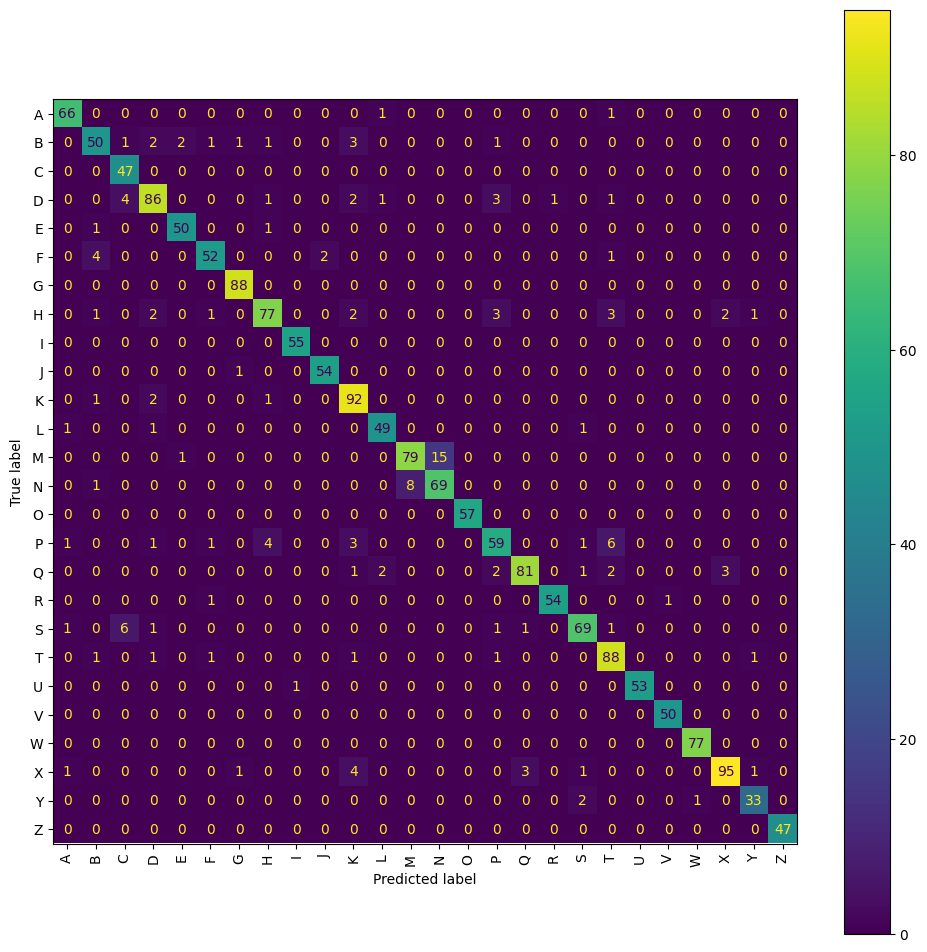

Saved: gesture_model_alphabet.pkl and label_encoder_alphabet.pkl


In [7]:
# === Confusion matrix visualization and save artifacts ===

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.show()

import joblib
joblib.dump(best_model, "gesture_model_alphabet.pkl")
joblib.dump(le, "label_encoder_alphabet.pkl")
print('Saved: gesture_model_alphabet.pkl and label_encoder_alphabet.pkl')


In [8]:
from google.colab import files

files.download("gesture_model_alphabet.pkl")
files.download("label_encoder_alphabet.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>